In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import feather
from evaluator import Evaluator
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype
from tqdm import tqdm_notebook as tqdm
from scipy import sparse

# Load data

In [2]:
training_ratings = feather.read_dataframe('./feather/training_ratings')
testing_ratings = feather.read_dataframe('./feather/testing_ratings')
book_profiles = feather.read_dataframe('./feather/book_profiles').set_index('book_id').to_sparse(fill_value=0)
novelty_scores = feather.read_dataframe('./feather/novelty_scores').set_index('book_id')
books = feather.read_dataframe('./feather/books').set_index('book_id')

In [3]:
book_sim = pd.DataFrame(
    data = cosine_similarity(book_profiles, book_profiles),
    index = book_profiles.index,
    columns = book_profiles.index
)

book_sim.head()

book_id,27,21,2,18,24,3275,3753,54,337,374,...,5111,5296,8713,7443,6428,7523,4594,9569,9580,8892
book_id,,,,,,,,,,,,,,,,,,,,,
27,1.000000,0.793039,0.967074,0.935959,0.932615,0.773161,0.826935,0.443948,0.383335,0.145548,...,0.191713,0.276920,0.220817,0.665664,0.613295,0.679846,0.121582,0.397349,0.165843,0.226996
21,0.793039,1.000000,0.781584,0.756703,0.802735,0.606846,0.642205,0.371239,0.290013,0.128655,...,0.132455,0.262205,0.181788,0.483300,0.445195,0.511246,0.116972,0.341285,0.114551,0.164359
2,0.967074,0.781584,1.000000,0.954254,0.951350,0.779767,0.838700,0.463165,0.400693,0.146866,...,0.159402,0.254301,0.199595,0.665316,0.612849,0.679313,0.122899,0.366076,0.148561,0.172504
18,0.935959,0.756703,0.954254,1.000000,0.919456,0.750132,0.813695,0.444069,0.384745,0.159378,...,0.153586,0.262145,0.192761,0.646410,0.607130,0.660081,0.135276,0.368633,0.142581,0.166399
24,0.932615,0.802735,0.951350,0.919456,1.000000,0.741594,0.802514,0.488001,0.413613,0.164158,...,0.157931,0.270466,0.198930,0.636164,0.583238,0.648697,0.139250,0.398710,0.146673,0.171259


In [4]:
evl = Evaluator(
    k = 10,
    training_ratings = training_ratings,
    testing_ratings = testing_ratings,
    book_sim = book_sim,
    novelty_scores = novelty_scores
)

# Create CF similarity matrix

In [5]:
training_ratings.head()

,user_id,book_id,rating
0,2,4081,4
1,2,2318,3
2,2,26,4
3,2,315,3
4,2,33,4


In [6]:
users_mean_rating = training_ratings.groupby('user_id').mean()[['rating']]
users_mean_rating.head()

,rating
user_id,
1,3.500000
2,4.269231
4,3.669355
5,3.945055
6,4.175676


In [7]:
training_ratings['adjusted_rating'] = training_ratings[['rating']] - users_mean_rating.loc[training_ratings.user_id].values
training_ratings.head()

,user_id,book_id,rating,adjusted_rating
0,2,4081,4,-0.269231
1,2,2318,3,-1.269231
2,2,26,4,-0.269231
3,2,315,3,-1.269231
4,2,33,4,-0.269231


In [8]:
user_c = CategoricalDtype(sorted(training_ratings.user_id.unique()), ordered=True)
book_c = CategoricalDtype(sorted(training_ratings.book_id.unique()), ordered=True)

row = training_ratings.user_id.astype(user_c).cat.codes
col = training_ratings.book_id.astype(book_c).cat.codes
sparse_matrix = csr_matrix((training_ratings["adjusted_rating"], (row, col)), \
                           shape=(user_c.categories.size, book_c.categories.size))

sparse_matrix

<52363x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 5206758 stored elements in Compressed Sparse Row format>

In [9]:
cf_sim = pd.DataFrame(
    data = cosine_similarity(sparse_matrix.T, sparse_matrix.T),
    index = book_c.categories,
    columns = book_c.categories)
cf_sim.shape

(10000, 10000)

In [10]:
cf_sim.head()

,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
1,1.000000,0.160908,-0.031925,0.057201,-0.032354,0.097614,0.003601,-0.033949,0.019652,0.062751,...,0.000213,-0.000544,-0.002776,0.006636,-0.001584,-0.004744,-0.003601,-0.001484,-0.008362,-0.001154
2,0.160908,1.000000,-0.140739,0.077358,-0.041489,0.055014,0.070666,-0.055633,0.000736,0.079883,...,-0.003834,-0.002613,0.003130,0.008077,-0.000640,-0.003086,0.001596,0.001712,-0.002568,0.001918
3,-0.031925,-0.140739,1.000000,-0.102555,0.018040,-0.030820,-0.074245,0.045801,0.092864,-0.042211,...,0.000588,0.000722,-0.001307,-0.012517,0.005616,-0.004577,-0.002103,-0.007541,-0.005134,-0.005772
4,0.057201,0.077358,-0.102555,1.000000,0.059419,0.029309,0.040175,0.021020,-0.066932,0.104644,...,-0.003452,-0.002976,0.003553,-0.007009,-0.010980,0.001920,0.001449,0.005182,-0.004473,0.002732
5,-0.032354,-0.041489,0.018040,0.059419,1.000000,0.002683,-0.022331,0.143918,-0.009220,0.022881,...,-0.003136,0.001688,-0.004796,0.002315,0.011939,-0.005000,0.004715,0.005097,-0.001746,0.007714


# Item-Item CF RecSys

Paper:
- Item-based Collaborative Filtering Recommendation Algorithms published by GroupLens
- Amazon. com recommendations: Item-to-item collaborative filtering

In [11]:
books.loc[2].title

"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"

In [12]:
books.loc[cf_sim.loc[2].sort_values(ascending=False)[1:11].index].title

23     Harry Potter and the Chamber of Secrets (Harry...
18     Harry Potter and the Prisoner of Azkaban (Harr...
24     Harry Potter and the Goblet of Fire (Harry Pot...
27     Harry Potter and the Half-Blood Prince (Harry ...
25     Harry Potter and the Deathly Hallows (Harry Po...
21     Harry Potter and the Order of the Phoenix (Har...
1                The Hunger Games (The Hunger Games, #1)
31                                              The Help
17                  Catching Fire (The Hunger Games, #2)
422             Harry Potter Boxset (Harry Potter, #1-7)
Name: title, dtype: object

In [13]:
top_sim_books = {}
book_ids = cf_sim.index
for book_id in tqdm(book_ids):
    top_sim_books[book_id] = cf_sim.loc[book_id].sort_values(ascending=False)[1:51]

In [14]:
list_of_5_ratings = training_ratings[training_ratings.rating==5].groupby('user_id')['book_id'].apply(list)

In [15]:
class ItemCFRecommender:
    name = "Item-based CF RS"
    preds = {}
    
    def fit(self, training_ratings):
        user_ids = training_ratings.user_id.unique().tolist()
        self.preds = {}
        for user_id in tqdm(user_ids):
            excluded_books = training_ratings[training_ratings.user_id==user_id].book_id.unique().tolist()
            most_similar_books = pd.Series([])
            for book_id in list_of_5_ratings[user_id]:
                most_similar_books = most_similar_books.append(top_sim_books[book_id])
            
            most_similar_books = np.array(most_similar_books.groupby(most_similar_books.index).sum().sort_values(ascending=False).index)
            recommendable = most_similar_books[~np.in1d(most_similar_books, excluded_books)]

            self.preds[user_id] = recommendable[:10].tolist()
    def recommendation_for_user(self, user_id):
        if user_id not in self.preds:
            return []
        return self.preds[user_id]
    
    def all_recommendation(self):
        return self.preds

In [16]:
icf_rec = ItemCFRecommender()
evl.evaluate(icf_rec)
evl.print_result()

Calculating recommendations:



Calculating metrics:



                       Item-based CF RS
Mean Average Precision           22.64%
Coverage                         85.54%
Novelty Score                      4.84
Diversity Score                    4.49
Personalization Score              9.58


# Inspection

In [17]:
def get_inspection(model):
    inspection = pd.DataFrame(columns=['5_counts', 'MAP'])
    preds = model.all_recommendation()
    for user_id in tqdm(preds.keys()):
        pred = preds[user_id]
        truth = evl.testing_idx[user_id]
        inspection.loc[user_id] = [len(list_of_5_ratings[user_id]), evl._average_precision(pred, truth)]
        
    return inspection

inspection = get_inspection(icf_rec)

In [18]:
inspection.head()

,5_counts,MAP
2,27.0,0.344444
4,21.0,0.237500
6,31.0,0.400000
8,15.0,0.017857
1,15.0,0.014286


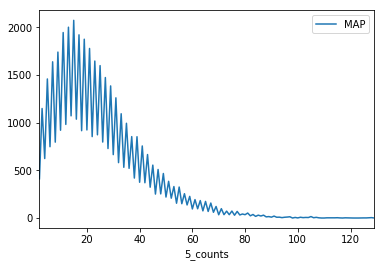

In [23]:
inspection.groupby('5_counts').count().plot()

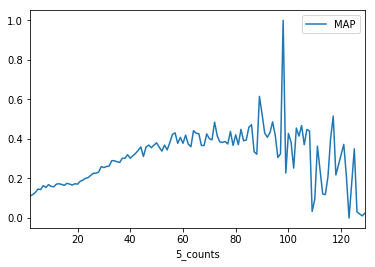

In [19]:
inspection.groupby('5_counts').mean().plot()